# Classifying Recessions based on yearly macrodata separated by country

##### Imbalanced Classes problem (0:    2367  =   94.7%; 1:     132  =    5.3%)

##### Data has been cleaned & organized as CSV files. Initial issues with null values (25-100% missing) for many of the original 48 features. The largest barrier is due to lack of data for all countries in 1870-1960 period. I've resolved this by reorganizing the data into 3 sets.

##### The primary dataset, data_1870 contains 27 of 48 original features; the secondary set data_1960 uses 32 features but <1000 rows due to removal of 90 years. I retained the larger NA riddled data-set to run decisiontreeclassifier which should handle the nulls.

#### Response variable is recession_coming  (note: recession_now, is a backward looking historical feature, does not forecast recessions but indicates a recession occured in that year for that country)

#### Plan is to use Fbeta to put emphasis on recall. Considering a theoretical loss coverage, a false negative (predicting no recession and having one) would result in 50-100% loss of assets/investments; a false positive would lead to fully hedging your portfolio (~10% cost) and potentiallyo some loss of upside but clearly the risk is skewed to false negative.

#### Taking 70% loss assumptions vs 10% cost... I'll use Fbeta = 7 (recall 7x more important than precision) for scoring/CV.

##### Initial EDA on the 3 data sets yielded no results I'll have to do EDA using subset of features so I will need to employ some domain knowledge before I begin this next step.

##### I'll start with a logistic regression but I think my "base-model" will be the random forest classifier on the larger data set full of NAs although I don't hope to draw comparisons between data sets, I am curious how well we can make predictions from the full data set.

##### for the remaining data sets, I plan to use classweights, oversampling, and random forests.  If time allows I will split original data set into specific sets of countries and try to build a stronger regression model.


### Feature engineering:  Money Supply (narrow + broad money); Rate_differential (long_irate-short_irate); 

In [3]:
import numpy as np
import pandas as pd
import pandas_profiling
from collections import defaultdict, Counter

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams['figure.figsize'] = (12, 10)

import sklearn
from sklearn import svm, datasets
from sklearn.utils import shuffle
from sklearn import cross_validation, metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve, fbeta_score, make_scorer, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
import xgboost as xgb
import imblearn.over_sampling
from scipy import interp

random_state = np.random.RandomState(42)

/Users/clarencestephen/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
data_1870 = pd.read_csv('data_1870.csv',na_values =np.nan) #fewer features but more data
data_1960 = pd.read_csv('data_1960.csv',na_values =np.nan) #threw out pre-1960 data (too many nulls)
data = pd.read_csv('data.csv',na_values=np.nan) #this one is for random forest

print(data.shape) #2499 rows, 44 features
print(data_1870.shape) #2499 rows,27 features
print(data_1960.shape) #969 rows, 32 features

(2499, 44)
(2499, 29)
(969, 35)


In [5]:
data_1960_clean = data_1960.fillna(data_1960.mean())

In [6]:
data_1870_clean = data_1870.fillna(data_1870.mean())

In [7]:
data_1870.isnull().sum().sum()

2437

In [8]:
data_1870.shape

(2499, 29)

In [12]:
pandas_profiling.ProfileReport(data_1870_clean)

Number of variables,14
Number of observations,2499
Total Missing (%),0.0%
Total size in memory,273.4 KiB
Average record size in memory,112.0 B
Numeric,11
Categorical,0
Boolean,3
Date,0
Text (Unique),0
Rejected,0


##### Drop columns that are highly correlated...choose ones with originally more nulls and lower variance

In [9]:
#drop column with lowest variation/std if it has no outliers
data_1870_clean = data_1870_clean.drop(columns=['country','narrow_money','broad_money','money_supply','exports','imports','consumption','real_gdp_index','mortgages','gov_expense','cpi','gov_revenue','private_loans','short_irate','long_irate'])  
data_1960_clean = data_1960_clean.drop(columns=['country','current_account','narrow_money','broad_money','money_supply','exports','imports','consumption','real_gdp_index','mortgages','gov_expense','cpi','gov_revenue','private_loans','short_irate','long_irate'])

In [10]:
data_1960_clean.columns  #housing_prices, electric_production, military_expense, pct_old, pop_growth extra cols

Index(['year', 'population', 'real_gdp_per_capita', 'nominal_gdp',
       'invest_gdp_ratio', 'trade_diff', 'yield_curve', 'stock_prices',
       'debt_to_gdp', 'usd_fx_rate', 'housing_prices', 'crudepx',
       'electric_production', 'military_expense', 'pct_old', 'pop_growth',
       'fin_crisis', 'recession_now', 'recession_coming'],
      dtype='object')

In [11]:
data_1870_clean.columns

Index(['year', 'population', 'real_gdp_per_capita', 'nominal_gdp',
       'invest_gdp_ratio', 'current_account', 'yield_curve', 'stock_prices',
       'debt_to_gdp', 'usd_fx_rate', 'crudepx', 'fin_crisis', 'recession_now',
       'recession_coming'],
      dtype='object')

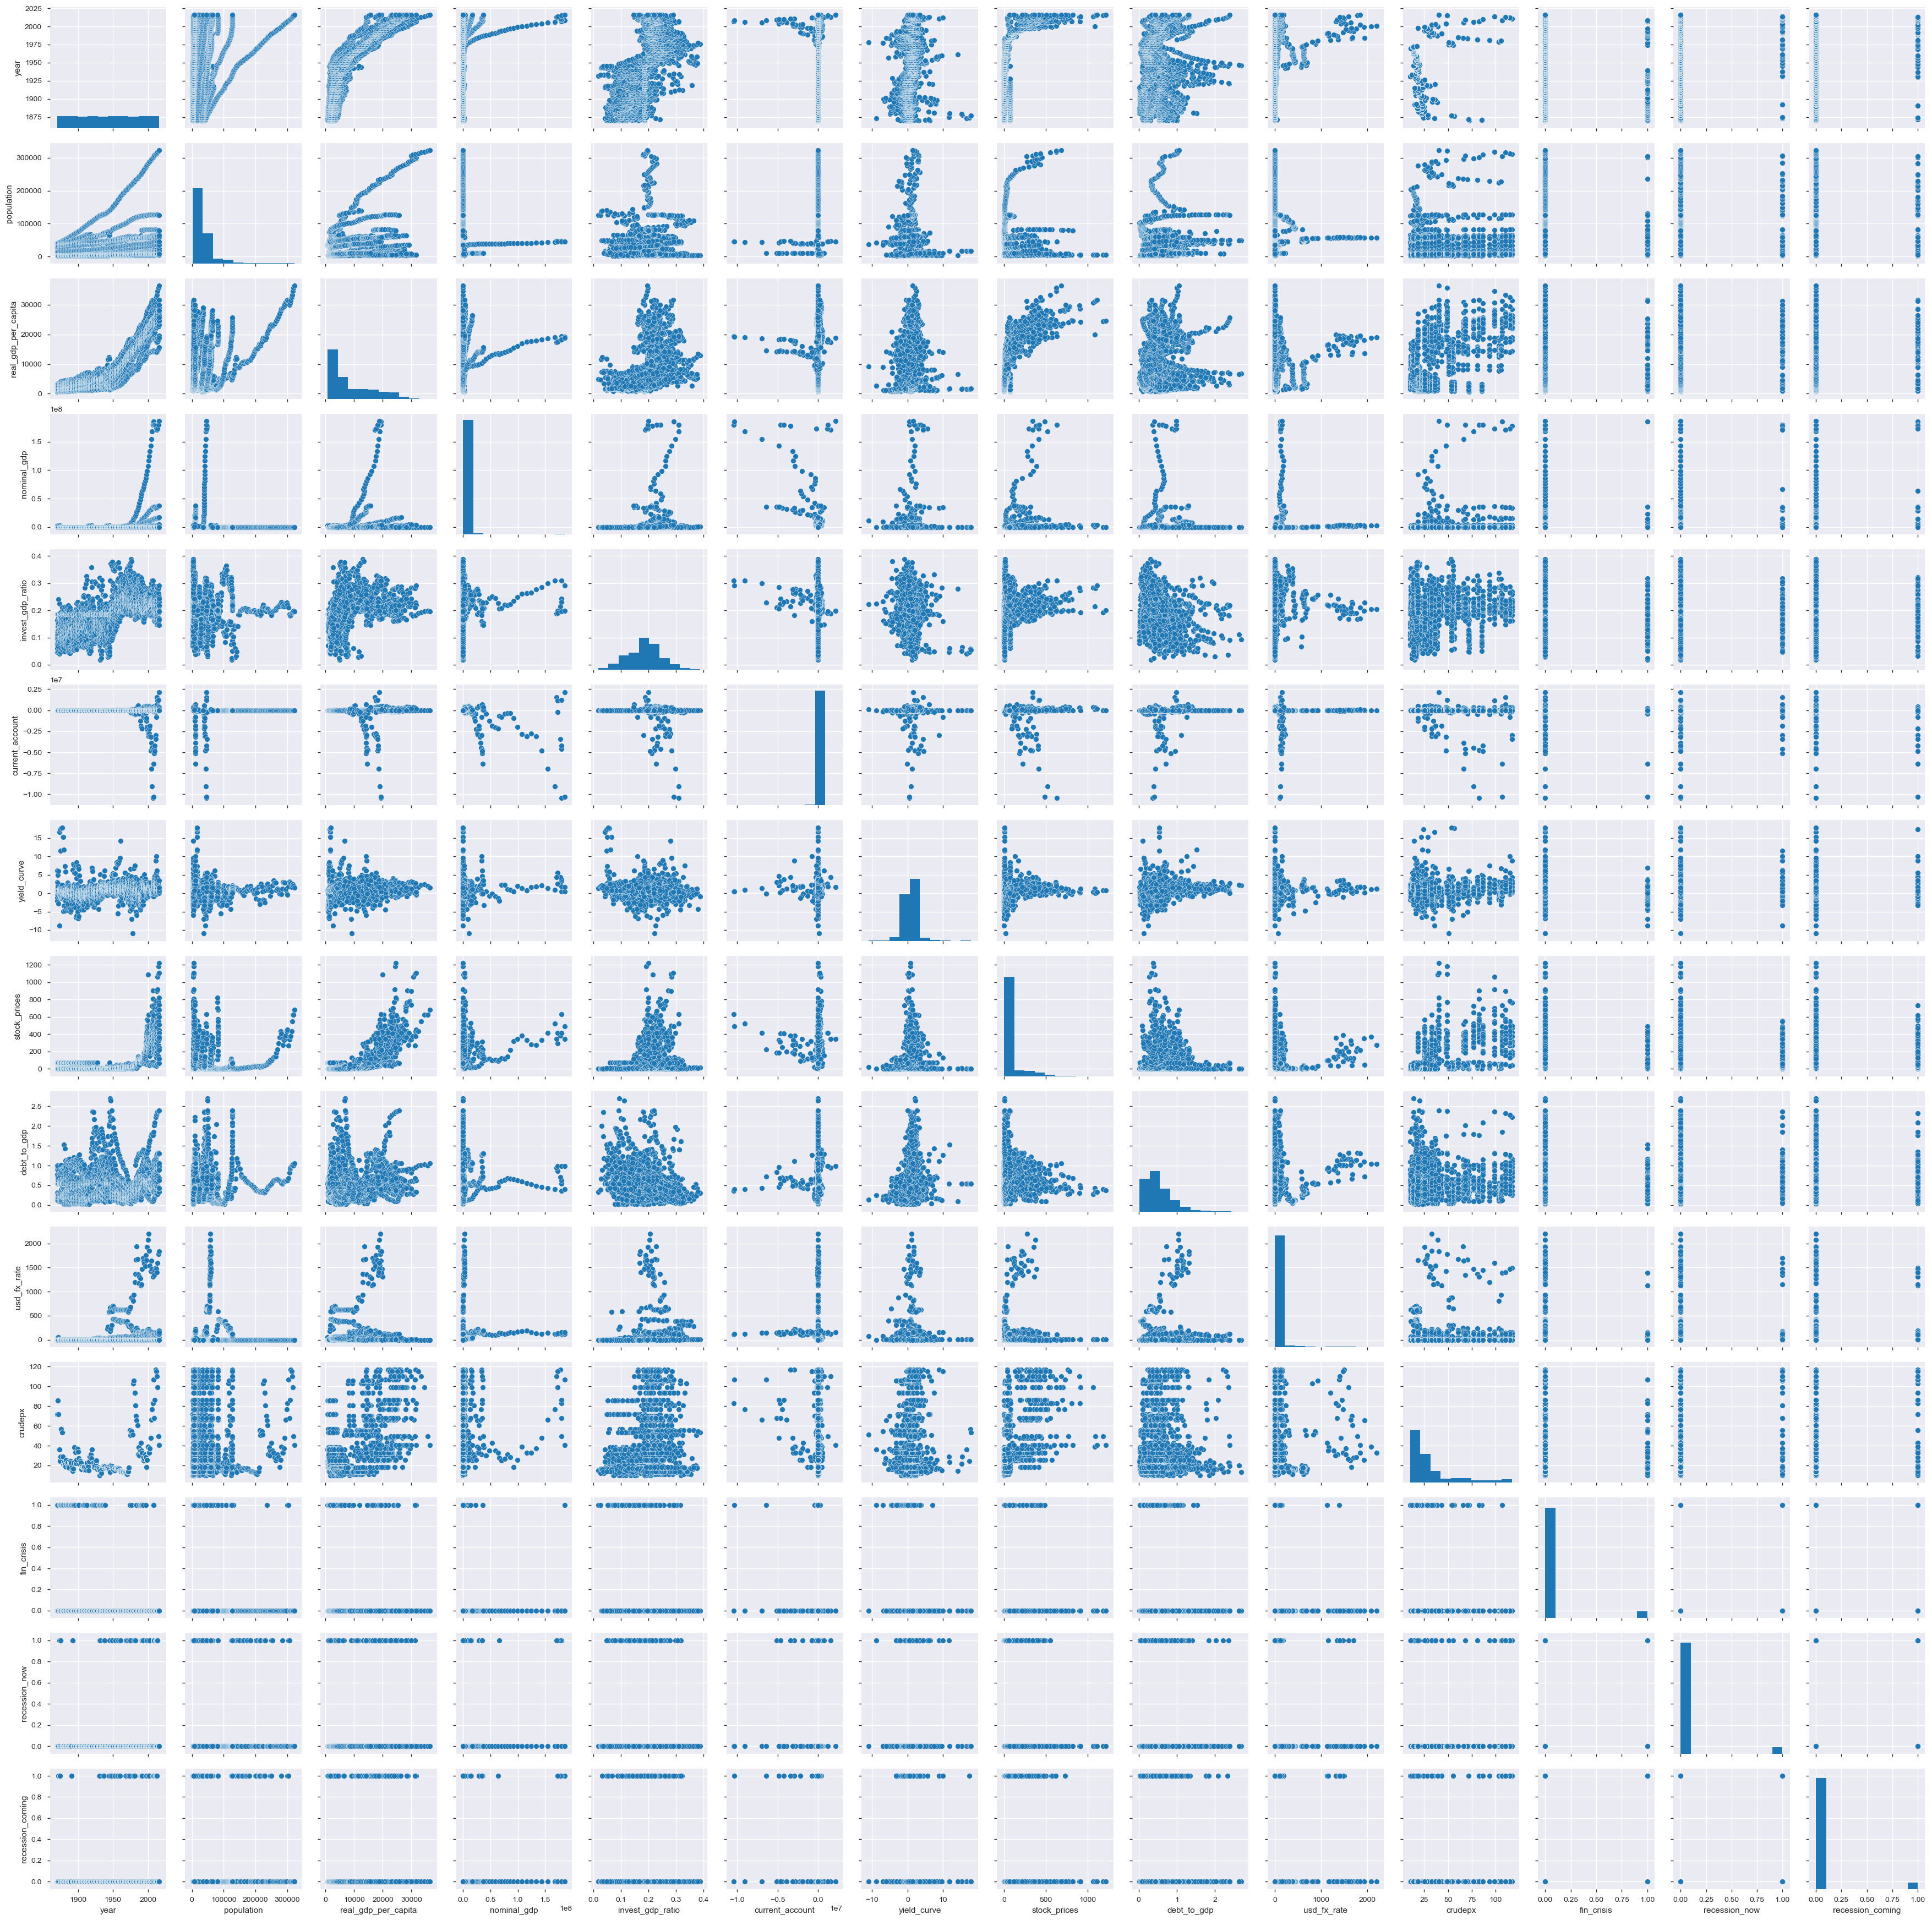

In [15]:
sns.pairplot(data_1870_clean)

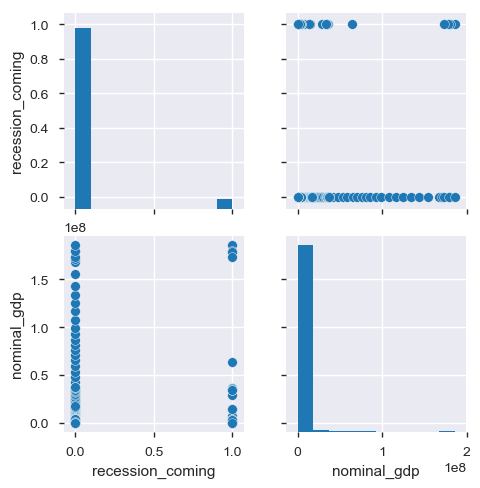

In [16]:
sns.pairplot(data_1870_clean[['recession_coming', 'nominal_gdp']])

### Assuming economies are driven by similiar dynamics, these dummies create noise. For determining future recessions we want to focus on macrodata, NOT country involved.  
 data_1870_dummies = pd.get_dummies(data_1870_clean)  
 data_1960_dummies = pd.get_dummies(data_1960_clean)
 
 moving forard without them

In [12]:
y = data_1870_clean['recession_coming']
x = data_1870_clean.drop(columns=['recession_coming'])
y_1960 = data_1960_clean['recession_coming']
x_1960 = data_1960_clean.drop(columns=['recession_coming'])

In [18]:
def class_info(classes):
    counts = Counter(classes)
    total = sum(counts.values())
    for cls in counts.keys():
        print("%6s: % 7d  =  % 5.1f%%" % (cls, counts[cls], counts[cls]/total*100))

print("Initial class percentages:")
class_info(y)

Initial class percentages:
     0:    2367  =   94.7%
     1:     132  =    5.3%


In [19]:
x_train, x_split, y_train, y_split = train_test_split(x, y, test_size=0.3, shuffle = False) #70% / 30% split
x_train_1960, x_split_1960, y_train_1960, y_split_1960 = train_test_split(x_1960, y_1960, test_size=0.3, shuffle = False) #70% / 30% split

In [20]:
x_test, x_holdout, y_test, y_holdout = train_test_split(x_split, y_split, test_size=0.333333, shuffle = False)  # 30% --> 20% & 10%
x_test_1960, x_holdout_1960, y_test_1960, y_holdout_1960 = train_test_split(x_split_1960, y_split_1960, test_size=0.333333, shuffle = False)  # 30% --> 20% & 10%

In [21]:
x_test['year'].unique()

array([1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002])

In [22]:
x_holdout['year'].unique()

array([2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016])

In [23]:
x_train['year'].unique()

array([1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880,
       1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891,
       1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902,
       1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913,
       1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924,
       1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935,
       1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946,
       1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957,
       1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968,
       1969, 1970, 1971, 1972])

### unbalanced classes
try with oversampling,weighting "balanced", blagging classifier

### logistic regression

This means that logistic regression is more robust to situations in
which the class conditional densities are not normal (and outliers

### handle colinearity of macrovariables
scaling, regularization, and dropped coorrelated columns

### linearsvm, svm
features are not on the same scale so not appropriate

### dtf, rf, 
rf will give feature importance, dtf should work well with moving pieces

### xgboost
gridsearch time permiting

### Fbeta = 7
f7_scorer = make_scorer(fbeta_score, beta=7)

f7_scorer(classifier,x_test,y_test)

### test-train-splits will yield progressively lower f7 scores bc its hard to predict the future with older data

### when training the model, get higher scores because it can easily predict the  past with the future

In [15]:
f7_scorer = make_scorer(fbeta_score, beta=7)

### We must scale data to see if regularization improves model. Used scaled training data for C-values <100000.


In [25]:
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
x_holdout_scaled = scaler.transform(x_holdout)

In [60]:
lr_no_reg_balanced = LogisticRegression(C = 100000, class_weight = 'balanced') #large C means no regularization
lr_no_reg_balanced.fit(x_train,y_train)

print('Logistic Regression with no scaling/regularization, balanced classes')
print('F7-score: ',f7_scorer(lr_no_reg_balanced,x_test,y_test))

Logistic Regression with no scaling/regularization, balanced classes
F7-score:  0.14822134387351776


In [45]:
lr_no_reg_balanced_scaled = LogisticRegression(C=100000, class_weight = 'balanced') #large C means no regularization
lr_no_reg_balanced_scaled.fit(x_train_scaled,y_train)

print('Logistic Regression with scaling but no regularization, balanced classes')
print('F7-score: ',f7_scorer(lr_no_reg_balanced_scaled,x_test_scaled,y_test))

Logistic Regression with scaling but no regularization, balanced classes
F7-score:  0.14955134596211364


In [49]:
lr_scaled_reg_balanced = LogisticRegression(class_weight = 'balanced') #large C means no regularization

parameters = {'C': np.linspace(0.0001,1,num=200, dtype=float)}

grid = GridSearchCV(lr_scaled_reg_balanced, parameters, cv=5, scoring = f7_scorer, n_jobs=-1)
grid.fit(x_train_scaled,y_train);

means = grid.cv_results_['mean_test_score']
ranks = grid.cv_results_['rank_test_score']
params = grid.cv_results_['params']

print("Tuning hyper-parameters for F7:")
print()    

"""for mean, rank, param in zip(means, ranks, params):
        print("%0.3f (#%0.0f) for %r"
              % (mean, rank, param))"""
print("The best C-value is:",grid.best_params_) #lower C is more regularization
print("with F7-score is:",max(means),"(this is on the training data)")

/Users/clarencestephen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Tuning hyper-parameters for F7:

The best C-value is: {'C': 0.0503462311557789}
with F7-score is: 0.6658652707412639 (this is on the training data)


In [50]:
lr_scaled_reg_balanced = LogisticRegression(C =0.0503462311557789, class_weight = 'balanced')
lr_scaled_reg_balanced.fit(x_train_scaled,y_train)

print('Logistic Regression with scaling & regularization, balanced classes')
print("F7-score:",f7_scorer(lr_scaled_reg_balanced,x_test_scaled,y_test))

Logistic Regression with scaling & regularization, balanced classes
F7-score: 0.17369727047146402


In [34]:
list(zip(x_test.columns, (lr_no_reg_balanced_scaled.coef_ / lr_scaled_reg_balanced.coef_).reshape(-1)))  #make this looks like the 

[('year', 1.621300237726751),
 ('population', 1.1841593492050086),
 ('real_gdp_per_capita', 2.24338906924911),
 ('nominal_gdp', 2.3140736085407734),
 ('invest_gdp_ratio', 2.700186578331596),
 ('current_account', 1.3484657015019543),
 ('yield_curve', 1.0207181132749739),
 ('stock_prices', 0.9920851218395913),
 ('debt_to_gdp', -5.054239613053414),
 ('usd_fx_rate', 24.46784422208543),
 ('crudepx', 1.5747007181860129),
 ('fin_crisis', -11.502377181758261),
 ('recession_now', 1.1281003969370413)]

###  Above, we see the result of regularizing the data. This decreases the signficiance of fin_crisis and USD_fx_rate as an influencer on recession probabilities

In [38]:
lr_scaled_reg_balanced.coef_

array([[-1.92887696e+00,  7.28352405e-01,  4.94260855e-01,
         2.38470248e-02,  9.64645890e-02,  2.01944905e-01,
         4.70001402e-02,  2.03273185e-01, -2.20237764e-02,
        -2.49598167e-01, -7.79033773e-01,  1.35974185e-03,
         1.89189745e-01]])

as xi increase by 1, you increase overall log(p(1)/1-p(1)) by *coeff 

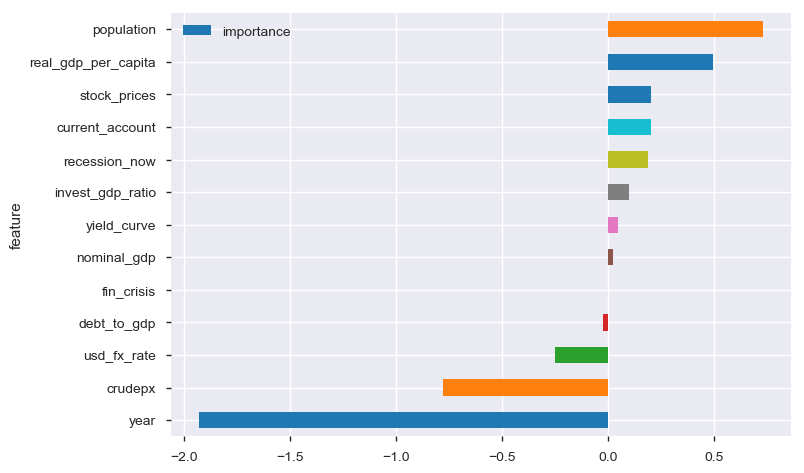

In [39]:
list(zip(x_test.columns, ))  #make this looks like the 

feat_imps2 = list(zip(x_test.columns,(lr_scaled_reg_balanced.coef_).reshape(-1)))
feat_imps2 = sorted(feat_imps2, key = lambda x: x[1], reverse=False)
feat_imps2 = pd.DataFrame(feat_imps2, columns=['feature','importance'])

feat_imps2.plot(x='feature',y='importance',kind='barh')

### comparing oversampling vs balanced class_weights

In [54]:
ROS = imblearn.over_sampling.RandomOverSampler(ratio=1.0, random_state=42) 
    
x_train_ros, y_train_ros = ROS.fit_sample(x_train, y_train)
x_train_ros_scaled, y_train_ros = ROS.fit_sample(x_train_scaled, y_train)

lr_ros = LogisticRegression(C=0.0503462311557789) 
lr_ros.fit(x_train_ros_scaled, y_train_ros)

print('Logistic Regression on oversampled data, regularized/scaled')
print('F7-score:',f7_scorer(lr_ros,x_test_scaled, y_test))

Logistic Regression on oversampled data, regularized/scaled
F7-score: 0.19801980198019803


/Users/clarencestephen/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/clarencestephen/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [59]:
lr_ros_no_reg_no_scale = LogisticRegression(C=100000) 
lr_ros_no_reg_no_scale.fit(x_train_ros, y_train_ros)

print('Logistic Regression on oversampled data, no regularization, no scaling')
print('F7-score:',f7_scorer(lr_ros_no_reg_no_scale,x_test, y_test))

Logistic Regression on oversampled data, no regularization, no scaling
F7-score: 0.14829461196243204


In [61]:
lr_ros_no_reg_yes_scale = LogisticRegression(C=100000) 
lr_ros_no_reg_yes_scale.fit(x_train_ros_scaled, y_train_ros)

print('Logistic Regression on oversampled data, no regularization, yes scaling')
print('F7-score:',f7_scorer(lr_ros_no_reg_yes_scale,x_test_scaled, y_test))

Logistic Regression on oversampled data, no regularization, yes scaling
F7-score: 0.14910536779324052


### Test Scores so far...

Logistic Regression - no scaling, no regularization, yes balanced
F7-score:  0.14822134387351776

Logistic Regression - no scaling, no regularization, yes oversampled
F7-score: 0.14829461196243204
    
Logistic Regression - yes scaling, no regularization, yes oversampled
F7-score: 0.14910536779324052

Logistic Regression - yes scaling, no regularization, yes balanced
F7-score:  0.14955134596211364

Logistic Regression - yes scaling, yes regularization, yes balanced
F7-score: 0.17369727047146402

Logistic Regression - yes scaling, yes regularization, yes oversampled
F7-score: 0.19801980198019803

### Undersampling inappropriate here due to constrained dataset size 

### Decision Trees overfit so don't work well

### Let's work through Random Forest parameters
n-estimators  (100-1000); more is sort of better with diminishing returns  
max features (default is sqrt of # of features)  
max depth (none to ~12)... number of splits its allowed to make (overfits less for less max depth; not as expressive)  min split = how many to make a split  
min leaf = how many to make a child  
bootstrap = True (recreates rows everytime)  

In [83]:
rf = RandomForestClassifier(n_estimators = 600, 
                            max_features = 7,
                            max_depth = None,
                            min_samples_split = 2,
                            min_samples_leaf = 4, 
                            n_jobs=-1, random_state=42)

rf.fit(x_train_ros,y_train_ros)

print('Random Forest Classifier, oversampled (no scaling/regularization necessary)')
print('F7-score:',f7_scorer(rf,x_test,y_test))

Random Forest Classifier, oversampled (no scaling/regularization necessary)
F7-score: 0.22635814889336014


### Random Forest with oversample  (0.2264) beats  Logistic Regression with oversampled data  (0.1980)

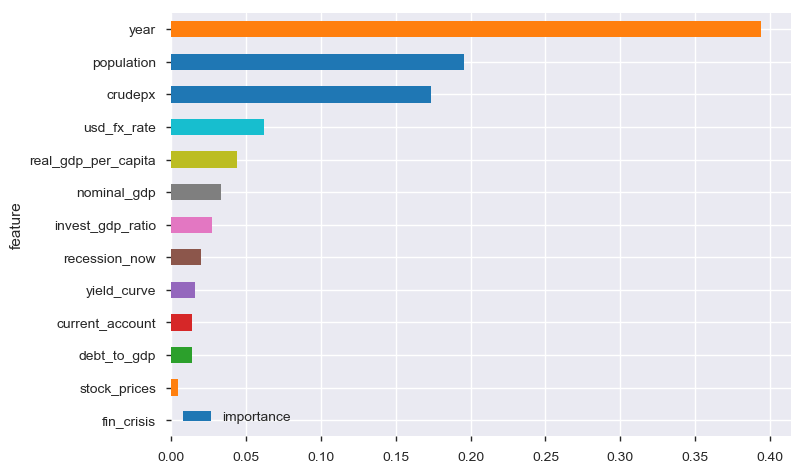

In [80]:
feat_imps = list(zip(x_train.columns,rf.feature_importances_))
feat_imps = sorted(feat_imps, key = lambda x: x[1], reverse=False)
feat_imps = pd.DataFrame(feat_imps, columns=['feature','importance'])

feat_imps.plot(x='feature',y='importance',kind='barh')

### Tree methods don't extrapolate well because its using < or > to make year splits  
### so they overfit to specific years (looking at absolute-value rather than any relative period of time)

In [104]:
gbm = xgb.XGBClassifier(
                       n_estimators=30000,
                       max_depth=4,
                       objective='binary:logistic',
                       learning_rate=.01,
                       subsample=.8,
                       min_child_weight=3,
                       colsample_bytree=1
                      )

eval_set=[(x_train,y_train),(x_test,y_test)]
fit_model = gbm.fit(
                   x_train, y_train,
                   eval_set=eval_set,
                   eval_metric='auc',
                   early_stopping_rounds=50,
                   verbose=False
                  )

In [105]:
f7_scorer(gbm,x_test,y_test)
#XGB attempts producing zero F7-score

/Users/clarencestephen/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/clarencestephen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [108]:
x_train_1960_final, x_val_1960, y_train_1960_final, y_val_1960 = train_test_split(x_1960, y_1960, test_size=0.1, shuffle = False) #90% / 10% split

In [109]:
#original split was 70%:30%  & 30% into 20%:10%
#now to combine training+test set (train on 90%, test on 10%)
    
x_train_final, x_val, y_train_final, y_val = train_test_split(x, y, test_size=0.1, shuffle = False) #90% / 10% split

In [111]:
#rescale....
x_train_final_scaled = scaler.fit_transform(x_train_final)
x_val_scaled = scaler.transform(x_val)

In [122]:
#new over-sampling w/ scaled data
    
x_train_final_ros_scaled, y_train_final_ros = ROS.fit_sample(x_train_final_scaled, y_train_final)
x_train_final_ros, y_train_final_ros = ROS.fit_sample(x_train_final, y_train_final)


/Users/clarencestephen/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/clarencestephen/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [188]:
x_train_final.tail()

,year,population,real_gdp_per_capita,nominal_gdp,invest_gdp_ratio,current_account,yield_curve,stock_prices,debt_to_gdp,usd_fx_rate,crudepx,fin_crisis,recession_now
2244,2002,19345.000,22236.93527,7.533880e+05,0.254578,-28924.124600,1.293124,234.962729,0.150620,1.766160,32.93,0,0
2245,2002,10355.000,21162.97468,1.083598e+07,0.206560,505458.947000,1.776667,197.400722,1.072159,38.466578,32.93,0,0
2246,2002,31641.000,23155.13657,1.154949e+03,0.206445,12.425751,3.075917,205.669532,0.805540,1.579600,32.93,0,0
2247,2002,5374.693,23074.60709,1.372737e+03,0.195851,27.318930,1.571033,229.965680,0.582495,7.082200,32.93,0,0
2248,2002,5206.295,20683.00071,8.816864e+05,0.230288,121508.006600,2.647367,483.649064,0.402322,5.669620,32.93,0,0


In [123]:
#F7-score: 0.22635814889336014
rf.fit(x_train_final_ros,y_train_final_ros)
print("Random Forest Classifier on oversampled (no scaling/regularization necessary)")
print("F7-score on holdout: ", f7_scorer(rf,x_val,y_val))

Random Forest Classifier on oversampled (no scaling/regularization necessary)
F7-score on holdout:  0.12071463061323033


In [116]:
#F7-score: 0.19801980198019803
lr_ros.fit(x_train_final_ros_scaled, y_train_final_ros)
print("Logistic Regression on oversampled data, regularized/scaled")
print("F7-score on holdout: ", f7_scorer(lr_ros,x_val_scaled,y_val))

Logistic Regression on oversampled data, regularized/scaled
F7-score on holdout:  0.5882352941176471


In [124]:
#F7-score: 0.17369727047146402
lr_scaled_reg_balanced.fit(x_train_final_scaled,y_train_final)
print("Logistic Regression on balanced data, regularized, scaled")
print("F7-score on holdout: ", f7_scorer(lr_scaled_reg_balanced,x_val_scaled,y_val))

Logistic Regression on balanced data, regularized, scaled
F7-score on holdout:  0.6726457399103138


In [16]:
final_model = LogisticRegression(C =0.0503462311557789, class_weight = 'balanced')
final_model.fit(x,y)
f7_scorer(final_model,x,y)

0.6433566433566433

In [190]:
x.columns

Index(['year', 'population', 'real_gdp_per_capita', 'nominal_gdp',
       'invest_gdp_ratio', 'current_account', 'yield_curve', 'stock_prices',
       'debt_to_gdp', 'usd_fx_rate', 'crudepx', 'fin_crisis', 'recession_now'],
      dtype='object')

In [202]:
x_2018 = pd.read_csv('2018.csv')

In [203]:
final_model.predict_proba(x_2018)

array([[0.01367302, 0.98632698]])

In [204]:
lr_scaled_reg_balanced.predict_proba(x_2018)

array([[0., 1.]])

In [205]:
rf.predict_proba(x_2018)

array([[0.4758064, 0.5241936]])

In [18]:
from sklearn.metrics import accuracy_score, recall_score
accuracy_score(y, final_model.predict(x))

0.7478991596638656

In [19]:
recall_score(y, final_model.predict(x))

0.696969696969697

In [140]:
thresh_ps = np.linspace(.10,.50,1000)
model_val_probs = final_model.predict_proba(x)[:,1] # positive class probs

f7_scores = []
f1_score()

for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f7_scores.append(f7_scorer(final_model, model_val_labels, y))
    
plt.plot(thresh_ps, f7_scores)
plt.title('F7 Score vs. Positive Class Decision Probability Threshold')
plt.xlabel('P threshold')
plt.ylabel('F7 score')

best_f7_score = np.max(f7_scores) 
best_thresh_p = thresh_ps[np.argmax(f7_scores)]

print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f7_score, best_thresh_p))

ValueError: Expected 2D array, got 1D array instead:
array=[ True  True  True ...  True  True  True].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.